In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler(color="rgb")

## Load and prepare data.

In [4]:
relax = pd.read_csv("relax.csv", dtype={"Time": np.float64})
mpi = pd.read_csv("mpi.csv", dtype={"Time": np.float64})

In [5]:
# get average of repeated runs
relax_avg = relax.groupby("N").mean().reset_index()
mpi_avg = mpi.groupby(["N", "Cores"]).mean().reset_index()

# convert time from ms to s
relax_avg["Time"] = relax_avg.Time.div(1000)
mpi_avg["Time"] = mpi_avg.Time.div(1000)

# add row for total number of elements
relax_avg["Size"] = relax_avg.N.pow(2)
mpi_avg["Size"] = mpi_avg.N.pow(2)

# add labels
fn = lambda x: f"MPI {int(x.Cores)} cores"
relax_avg["Label"] = "Sequential"
mpi_avg["Label"] = mpi_avg.apply(fn, axis=1)

In [6]:
relax_avg.head()

,N,Size,Iterations,Time,Label
0,100,10000,331,0.0070,Sequential
1,200,40000,405,0.0319,Sequential
2,300,90000,445,0.0805,Sequential
3,400,160000,445,0.1413,Sequential
4,500,250000,445,0.2211,Sequential


### Performance metrics.

In [7]:
# add flops
fn = lambda x: (9 * x.Iterations * x.N * x.N) / x.Time
relax_avg["FLOPS"] = relax_avg.apply(fn, axis=1)
mpi_avg["FLOPS"] = mpi_avg.apply(fn, axis=1)

In [8]:
# calculate speedup
fn = lambda x: (relax_avg.loc[relax_avg.N == x.N].iloc[0].Time) / x.Time
mpi_avg["Speedup"] = mpi_avg.apply(fn, axis=1)

# calculate efficiency
fn = lambda x: x.Speedup / x.Cores
mpi_avg["Efficiency"] = mpi_avg.apply(fn, axis=1)

In [9]:
# calculate memory usage
fn = lambda x: 16 * (x.N * x.N + 2 * x.N * (x.Cores - 1)) / 1000000
relax_avg["Memory"] = 16 * relax_avg.Size / 1000000 
mpi_avg["Memory"] = mpi_avg.apply(fn, axis=1)

In [10]:
mpi_avg.head()

,N,Cores,Size,Iterations,Time,Label,FLOPS,Speedup,Efficiency,Memory
0,100,1,10000,331.000000,0.006400,MPI 1 cores,4.654688e+09,1.093750,1.093750,0.1600
1,100,2,10000,300.500000,0.004400,MPI 2 cores,6.146591e+09,1.590909,0.795455,0.1632
2,100,3,10000,254.538462,0.002846,MPI 3 cores,8.048919e+09,2.459459,0.819820,0.1664
3,100,4,10000,218.384615,0.003077,MPI 4 cores,6.387750e+09,2.275000,0.568750,0.1696
4,100,5,10000,182.941176,0.002588,MPI 5 cores,6.361364e+09,2.704545,0.540909,0.1728


## Combine data for easier processing.

In [11]:
# combine data
combined = pd.concat([relax_avg, mpi_avg])
combined = combined.fillna(0)
combined = combined.astype({"Cores": "int64"})

# drop irrelevant columns
combined.drop("Speedup", axis=1, inplace=True)
combined.drop("Efficiency", axis=1, inplace=True)

# select only thousands
combined_small = combined[combined.N % 1000 == 0]

In [12]:
combined.head()

,N,Size,Iterations,Time,Label,FLOPS,Memory,Cores
0,100,10000,331.0,0.0070,Sequential,4.255714e+09,0.16,0
1,200,40000,405.0,0.0319,Sequential,4.570533e+09,0.64,0
2,300,90000,445.0,0.0805,Sequential,4.477640e+09,1.44,0
3,400,160000,445.0,0.1413,Sequential,4.535032e+09,2.56,0
4,500,250000,445.0,0.2211,Sequential,4.528494e+09,4.00,0


### Create subsetscontaining less data.

In [13]:
# select only thousands
relax_small = relax_avg[relax_avg.N % 1000 == 0]
mpi_small = mpi_avg[mpi_avg.N % 1000 == 0]

In [14]:
# select fewer cores
cores = [0, 1, 2, 4, 8]
subset = combined[combined.Cores.isin(cores)]
subset_small = combined_small[combined_small.Cores.isin(cores)]

In [15]:
subset_small.head()

,N,Size,Iterations,Time,Label,FLOPS,Memory,Cores
9,1000,1000000,445.0,2.0258,Sequential,1.976997e+09,16.0,0
19,2000,4000000,445.0,5.4699,Sequential,2.928756e+09,64.0,0
29,3000,9000000,445.0,11.9903,Sequential,3.006180e+09,144.0,0
39,4000,16000000,445.0,22.4216,Sequential,2.857958e+09,256.0,0
49,5000,25000000,445.0,33.4719,Sequential,2.991315e+09,400.0,0


---

## Plot performance.

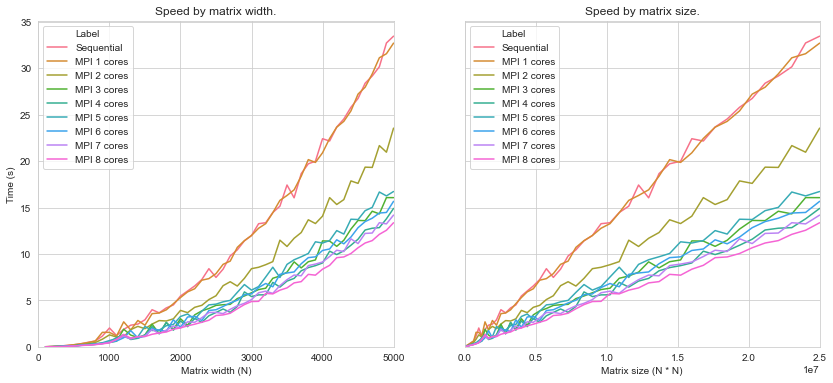

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

sns.lineplot(x="N", y="Time", hue="Label", data=combined, ax=axs[0])
sns.lineplot(x="Size", y="Time", hue="Label", data=combined, ax=axs[1])

axs[0].set_title("Speed by matrix width.")
axs[1].set_title("Speed by matrix size.")
axs[0].set_xlabel("Matrix width (N)")
axs[1].set_xlabel("Matrix size (N * N)")
axs[0].set_ylabel("Time (s)")

axs[0].set_xlim(0, 5000)
axs[1].set_xlim(0, 5000 * 5000)
axs[0].set_ylim(bottom=0)

plt.savefig("speed.png", format="png", bbox_inches="tight")
plt.show()

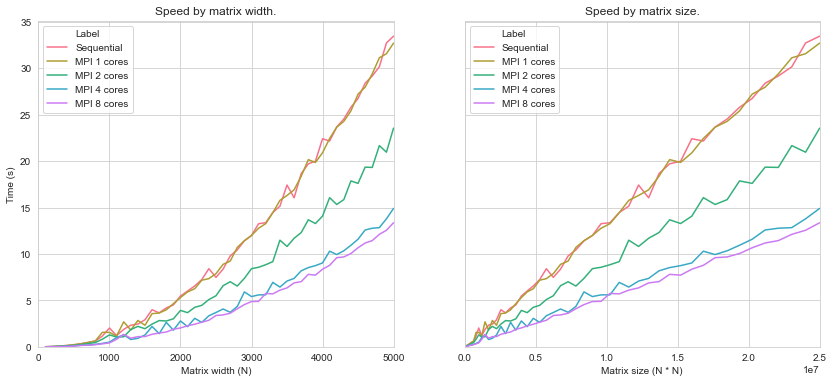

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

sns.lineplot(x="N", y="Time", hue="Label", data=subset, ax=axs[0])
sns.lineplot(x="Size", y="Time", hue="Label", data=subset, ax=axs[1])

axs[0].set_title("Speed by matrix width.")
axs[1].set_title("Speed by matrix size.")
axs[0].set_xlabel("Matrix width (N)")
axs[1].set_xlabel("Matrix size (N * N)")
axs[0].set_ylabel("Time (s)")

axs[0].set_xlim(0, 5000)
axs[1].set_xlim(0, 5000 * 5000)
axs[0].set_ylim(bottom=0)

plt.savefig("speed-small.png", format="png", bbox_inches="tight")
plt.show()

---

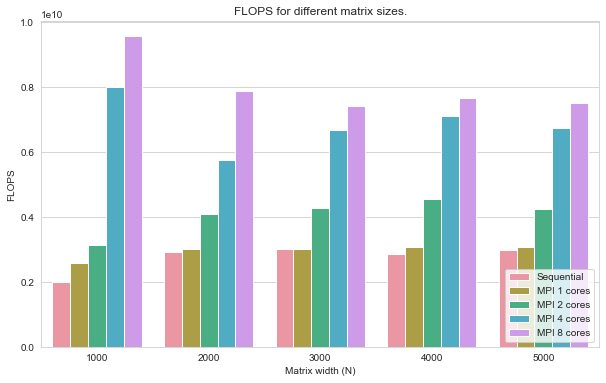

In [18]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x="N", y="FLOPS", hue="Label", data=subset_small)

ax.set_title("FLOPS for different matrix sizes.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("FLOPS")
plt.legend(loc="lower right")

plt.savefig("flops.png", format="png", bbox_inches="tight")
plt.show()

## Plot improvement.

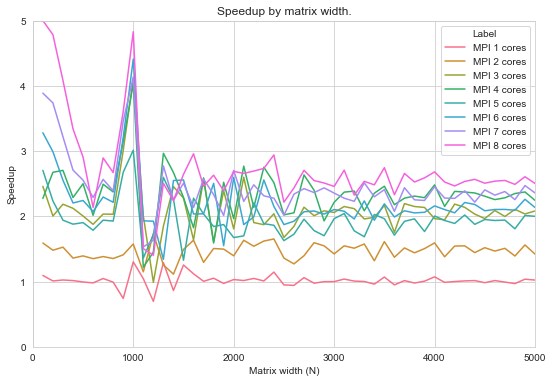

In [19]:
plt.figure(figsize=(9, 6))

ax = sns.lineplot(x="N", y="Speedup", hue="Label", data=mpi_avg)

ax.set_title("Speedup by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Speedup")

ax.set_xlim(0, 5000)
ax.set_ylim(0, 5)

plt.savefig("speedup-line.png", format="png", bbox_inches="tight")
plt.show()

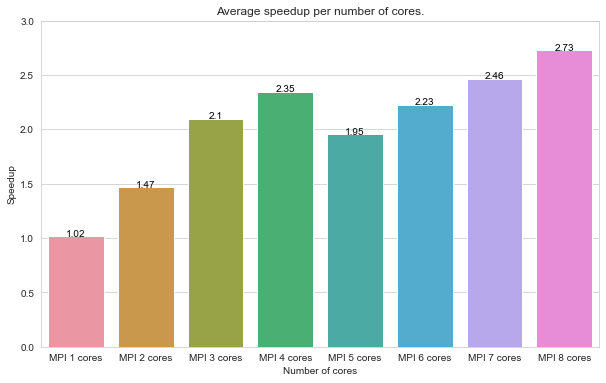

In [20]:
plt.figure(figsize=(10, 6))

labels = [f"MPI {i} cores" for i in range(1, 9)]
speedup = mpi_avg.groupby("Cores").Speedup.mean()
avg_speedup = pd.DataFrame(zip(labels, speedup), columns=["Label", "Speedup"])
ax = sns.barplot(x="Label", y="Speedup", data=avg_speedup)

ax.set_title("Average speedup per number of cores.")
ax.set_xlabel("Number of cores")
ax.set_ylabel("Speedup")

ax.set_ylim(0, 3)

for index, row in avg_speedup.iterrows():
    ax.text(row.name,row.Speedup, round(row.Speedup, 2), color='black', ha="center")

plt.savefig("speedup-bar.png", format="png", bbox_inches="tight")
plt.show()

---

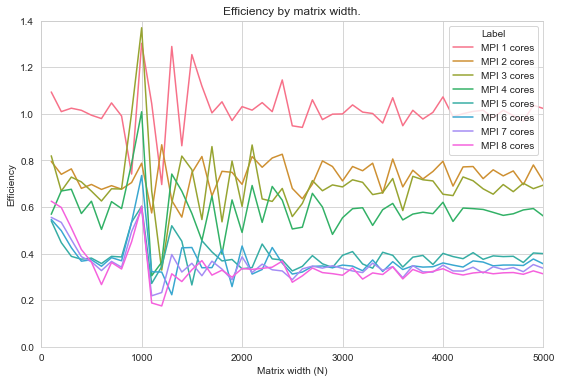

In [21]:
plt.figure(figsize=(9, 6))

ax = sns.lineplot(x="N", y="Efficiency", hue="Label", data=mpi_avg)

ax.set_title("Efficiency by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Efficiency")

ax.set_xlim(0, 5000)
ax.set_ylim(0.0, 1.4)
plt.legend(loc="upper right")

plt.savefig("efficiency-line.png", format="png", bbox_inches="tight")
plt.show()

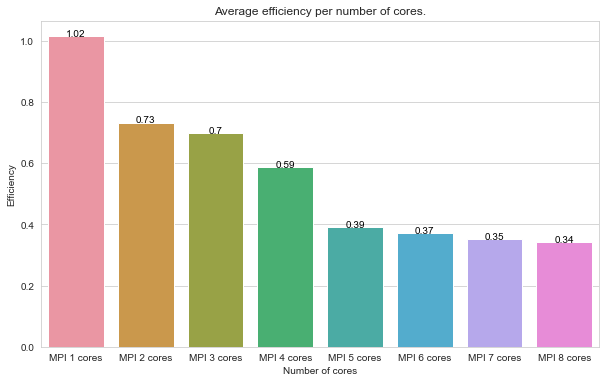

In [22]:
plt.figure(figsize=(10, 6))

labels = [f"MPI {i} cores" for i in range(1, 9)]
efficiency = mpi_avg.groupby("Cores").Efficiency.mean()
avg_speedup = pd.DataFrame(zip(labels, efficiency), columns=["Label", "Efficiency"])
ax = sns.barplot(x="Label", y="Efficiency", data=avg_speedup)

ax.set_title("Average efficiency per number of cores.")
ax.set_xlabel("Number of cores")
ax.set_ylabel("Efficiency")

for index, row in avg_speedup.iterrows():
    ax.text(row.name,row.Efficiency, round(row.Efficiency, 2), color='black', ha="center")

plt.savefig("efficiency-bar.png", format="png", bbox_inches="tight")
plt.show()

---

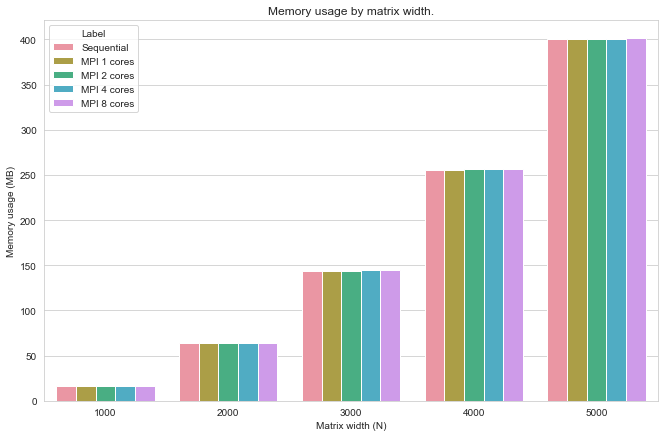

In [23]:
plt.figure(figsize=(11, 7))
ax = sns.barplot(x="N", y="Memory", hue="Label", data=subset_small)

ax.set_title("Memory usage by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Memory usage (MB)")

ax.set_ylim(0.)

plt.savefig("memory.png", format="png", bbox_inches="tight")
plt.show()